In [0]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
os.listdir('/content/gdrive/My Drive/dataset/aerial_cactus')

['train.csv', 'test', 'train']

In [0]:
train_path = '/content/gdrive/My Drive/dataset/aerial_cactus/train'
test_path = '/content/gdrive/My Drive/dataset/aerial_cactus/test'

train_df = pd.read_csv('/content/gdrive/My Drive/dataset/aerial_cactus/train.csv')

In [0]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [0]:
# 파일명인 id열을 path를 포함한 파일명으로 변경
filename = train_df['id']
train_path = [os.path.join(train_path, fname) for fname in filename]
train_path[0]

'/content/gdrive/My Drive/dataset/aerial_cactus/train/0004be2cfeaba1c0361d39e2b000257b.jpg'

In [0]:
# dataframe 다시 만들기
train_df = pd.DataFrame({'id':train_path, 'has_cactus':train_df['has_cactus']}, dtype = np.str)
train_df.head()

,id,has_cactus
0,/content/gdrive/My Drive/dataset/aerial_cactus...,1
1,/content/gdrive/My Drive/dataset/aerial_cactus...,1
2,/content/gdrive/My Drive/dataset/aerial_cactus...,1
3,/content/gdrive/My Drive/dataset/aerial_cactus...,1
4,/content/gdrive/My Drive/dataset/aerial_cactus...,1


In [0]:
# test set에 대한 label이 없으므로 train set에서 train, test data 나누기
train_df = train_df[:-500]
test_df = train_df[-500:]

In [0]:
train_df.shape[0]

17000

In [0]:
# image 형태 확인
image = Image.open(train_df['id'][0])
image = np.array(image)
image.shape

(32, 32, 3)

In [0]:
# hyper parameter
input_shape = (32, 32, 3)
batch_size = 32
num_classes = 2
epochs = 10
learning_rate = 0.01

In [0]:
# VGG 함수들
def CNN(inputs, filters):
  net = layers.Conv2D(filters, (3,3), padding = 'SAME')(inputs)
  net = layers.Conv2D(filters, (3,3), padding = 'SAME')(net)
  net = layers.Conv2D(filters, (3,3), padding = 'SAME')(net)
  net = layers.BatchNormalization()(net)
  net = layers.MaxPool2D()(net)
  net = layers.Dropout(0.3)(net)

  return net

def fully_connected(inputs, num_classes):
  net = layers.Flatten()(inputs)
  net = layers.Dense(512)(net)
  net = layers.Activation('relu')(net)
  net = layers.Dropout(0.5)(net)
  net = layers.Dense(num_classes)(net)
  net = layers.Activation('softmax')(net)

  return net

def VGG(inputs, num_classes):
  net = CNN(inputs, 64)
  net = CNN(net, 128)
  net = CNN(net, 256)
  net = CNN(net, 512)
  net = CNN(net, 512)
  net = fully_connected(net, num_classes)

  return net

In [0]:
#model 만들기
inputs = tf.keras.Input(input_shape)
net = VGG(inputs, num_classes)
model = tf.keras.Model(inputs = inputs, outputs = net)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#model compile
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy']
)

In [0]:
#image generator 틀 만들기
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    width_shift_range = 0.3,
    horizontal_flip = True,
    rescale = 1./255.
)

test_datagen = ImageDataGenerator(rescale = 1./255.)

In [0]:
#image generator
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col = 'id', y_col = 'has_cactus',
    target_size = input_shape[:2],
    class_mode = 'sparse'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'id', y_col = 'has_cactus',
    target_size = input_shape[:2],
    class_mode = 'sparse'
)

Found 17000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [0]:
#학습, 평가
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_df.shape[0]//32,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test_df.shape[0]//32,
)

Epoch 1/10
531/531 [==============================] - 5386s 10s/step - loss: 0.5508 - acc: 0.8013 - val_loss: 0.6671 - val_acc: 0.8333
Epoch 2/10
531/531 [==============================] - 56s 106ms/step - loss: 0.3597 - acc: 0.8280 - val_loss: 10.5802 - val_acc: 0.7500
Epoch 3/10
531/531 [==============================] - 49s 92ms/step - loss: 0.3701 - acc: 0.8153 - val_loss: 2.2243 - val_acc: 0.7500
Epoch 4/10
531/531 [==============================] - 49s 91ms/step - loss: 0.3665 - acc: 0.8243 - val_loss: 9.3437 - val_acc: 0.7563
Epoch 5/10
531/531 [==============================] - 50s 94ms/step - loss: 0.3440 - acc: 0.8497 - val_loss: 0.2785 - val_acc: 0.9021
Epoch 6/10
531/531 [==============================] - 49s 93ms/step - loss: 0.3699 - acc: 0.8129 - val_loss: 0.4691 - val_acc: 0.7437
Epoch 7/10
531/531 [==============================] - 49s 93ms/step - loss: 0.3360 - acc: 0.8398 - val_loss: 0.5776 - val_acc: 0.5708
Epoch 8/10
531/531 [==============================] - 49s 9

In [0]:
#test filename 불러오기
test_filename = pd.read_csv('/content/gdrive/My Drive/dataset/aerial_cactus/sample_submission.csv')

In [0]:
test_filename.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [0]:
# 파일위치+파일명 형태로 저장
test_list = [os.path.join(test_path, fname) for fname in test_filename['id']]
test_list[0]

'/content/gdrive/My Drive/dataset/aerial_cactus/test/000940378805c44108d287872b2f04ce.jpg'

In [0]:
# 학습시킨 모델로 예측
preds = []
for test in tqdm_notebook(test_list):
  image_pil = Image.open(test)
  image = np.array(image_pil)
  image = image[tf.newaxis, ...]
  pred = model.predict(image)
  preds.append(pred)

In [0]:
# 0,1 중 하나로 표현
predictions = [np.argmax(i) for i in preds]

In [0]:
# 저장
sub_df = pd.DataFrame({'id':test_filename['id'], 'has_cactus':predictions})
sub_df.to_csv('/content/gdrive/My Drive/dataset/aerial_cactus/test_prediction.csv', index = False)

In [0]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
history.history['loss']

[0.5513882231123601,
 0.3594892509755859,
 0.3701310078668347,
 0.36688444512961665,
 0.3441312679812797,
 0.37008328407735885,
 0.33624623710959656,
 0.33041674897728074,
 0.3036913406604419,
 0.2770170962428327]

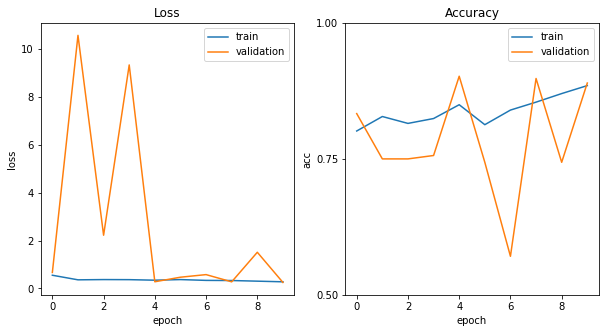

In [0]:
plt.figure(figsize=(10,5))


plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])

plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.yticks([0.5,0.75,1])
plt.ylabel('acc')
plt.legend(['train', 'validation'])
plt.show()

In [0]:
save_path = '/content/gdrive/My Drive/dataset/aerial_cactus/model.h5'
model.save(save_path)

# 모델 불러오기 : tf.keras.models.load_model(save_path)